In [8]:
"""
Standalone implementation of the Kang-Schafer continuous treatment simulation.
This script directly implements the permutation weighting approach from the R code,
without relying on external packages.

Based on the R implementation in:
- run_ks_continuous_sim.R
- kang_schafer_continuous.R
- continuous_simulation.R
- weighting.R
- weighting-class.R
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from skmisc.loess import loess
import time

from joblib import Parallel, delayed



# Set random seed for reproducibility
np.random.seed(100)

def create_kang_schafer_continuous_dgp(n, misspecified=False, extraneous_covs=0, trt_noise_sd=1, logit=True):
    """
    Generate data according to Kang and Schafer (2007) simulation with continuous treatment.
    Directly matches the create_kang_schafer_continuous_dgp function in kang_schafer_continuous.R
    """
    # Generate true covariates (matching R's mvrnorm)
    sigma = np.eye(4 + extraneous_covs)
    mus = np.zeros(4 + extraneous_covs)
    X_true = np.random.multivariate_normal(mus, sigma, n)
    
    # Set coefficients for treatment (matches R)
    co = np.zeros(4 + extraneous_covs)
    co[:4] = np.array([1, -0.5, 0.25, 0.1])
    
    # Linear predictor for treatment
    z_score = np.dot(X_true, co)
    
    # Treatment function: R uses 1/(1+exp(z)) which decreases as z increases
    trt_fn = lambda z: 1 / (1 + np.exp(z)) if logit else z
    
    # True outcome (without treatment effect)
    Outcome = 210 + 27.4 * X_true[:, 0] + 13.7 * X_true[:, 1] + 13.7 * X_true[:, 2] + 13.7 * X_true[:, 3]
    
    # Random noise for outcome
    outcome_noise = np.random.normal(0, 1, n)
    
    # Function to draw dosage (treatment value)
    def draw_dose():
        noise = np.random.normal(0, trt_noise_sd, n)
        return z_score + noise
    
    # Function to calculate test points for evaluation
    def draw_test_points(n_points):
        q = np.linspace(0.05, 0.95, n_points)
        Vz_score = np.dot(np.dot(co, sigma), co)
        Ez_score = np.sum(mus * co)
        test_noise = norm.ppf(q, loc=Ez_score, scale=np.sqrt(Vz_score) + trt_noise_sd)
        return Ez_score + test_noise
    
    # Function to draw outcomes given treatment values
    def draw_outcome(A):
        return Outcome + trt_fn(A) + outcome_noise
    
    # Generate observed covariates (potentially misspecified)
    if misspecified:
        X = np.column_stack([
            np.exp(X_true[:, 0] / 2),
            X_true[:, 1] * (1 + np.exp(X_true[:, 0])) ** (-1) + 10,
            (X_true[:, 0] * X_true[:, 2] / 25 + 0.6) ** 3,
            (X_true[:, 1] + X_true[:, 3] + 20) ** 2
        ])
        
        # Add extraneous covariates if specified
        if extraneous_covs > 0:
            X = np.column_stack([X, X_true[:, 4:]])
    else:
        X = X_true.copy()
    
    return {
        'draw_dose': draw_dose,
        'draw_outcome': draw_outcome,
        'draw_test_points': draw_test_points,
        'data': X,
        'X': X,
        'X_true': X_true,
        'Outcome': Outcome,
        'trt_fn': trt_fn,
        'z_score': z_score,
        'outcome_noise': outcome_noise
    }

def create_dataset(features, outcome, N):
    # Match R's implementation exactly
    sampled_ids = np.random.permutation(N)
    
    # Function to bootstrap both A and X from same indices
    def bootstrap_all(size):
        idx = sampled_ids[np.random.choice(N, size=size, replace=True)]
        data = {'a': outcome[idx], 'label': np.zeros(size)}
        for i in range(features.shape[1]):
            data[f'X{i}'] = features[idx, i]
        return pd.DataFrame(data)
    
    # Function to bootstrap treatment
    def bootstrap_a(size):
        idx = np.random.choice(N, size=size, replace=True)
        return outcome[sampled_ids[idx]]
    
    # Function to bootstrap features
    def bootstrap_x(size):
        idx = sampled_ids[np.random.choice(N, size=size, replace=True)]
        return features[idx, :]
    
    # Create original and permuted datasets
    original_data = bootstrap_all(N)
    
    # Create permuted data with separate bootstrapping for A and X
    permuted_data = pd.DataFrame({'a': bootstrap_a(N), 'label': np.ones(N)})
    bootstrapped_x = bootstrap_x(N)
    for i in range(features.shape[1]):
        permuted_data[f'X{i}'] = bootstrapped_x[:, i]
    
    return pd.concat([original_data, permuted_data], ignore_index=True)

# def create_dataset(features, outcome, N):
#     # Match R's implementation structure
#     sampled_ids = np.random.permutation(N)
#     
#     # Function to bootstrap treatment
#     def bootstrap_a(size):
#         idx = np.random.choice(N, size=size, replace=True)
#         return outcome[sampled_ids[idx]]
#     
#     # Function to bootstrap features
#     def bootstrap_x(size):
#         idx = sampled_ids[np.random.choice(N, size=size, replace=True)]
#         return features[idx, :]
#     
#     # Create original data with consistent bootstrapping
#     bootstrap_idx = np.random.choice(N, size=N, replace=True)
#     original_data = pd.DataFrame({'a': outcome[bootstrap_idx], 'label': np.zeros(N)})
#     for i in range(features.shape[1]):
#         original_data[f'X{i}'] = features[bootstrap_idx, i]
#     
#     # Create permuted data with separate bootstrapping for A and X
#     permuted_data = pd.DataFrame({
#         'a': bootstrap_a(N),  # Bootstrapped treatments
#         'label': np.ones(N)
#     })
#     
#     # Get bootstrapped features
#     bootstrapped_x = bootstrap_x(N)
#     for i in range(features.shape[1]):
#         permuted_data[f'X{i}'] = bootstrapped_x[:, i]
#     
#     return pd.concat([original_data, permuted_data], ignore_index=True) 

# def create_dataset(features, outcome, N):
#     """
#     Create permuted datasets for permutation weighting.
#     This matches the create.dataset function in weighting.R
#     """
#     # Sample indices for permutation
#     sampled_ids = np.random.permutation(N)
#     
#     # Create observed data
#     idx = np.random.choice(N, size=N, replace=True)
#     original_data = pd.DataFrame({
#         'a': outcome[idx],
#         'label': np.zeros(N)
#     })
#     
#     # Add feature columns to original data
#     for i in range(features.shape[1]):
#         original_data[f'X{i}'] = features[idx, i]
#     
#     # Bootstrap treatments for permuted data
#     perm_idx = np.random.choice(N, size=N, replace=True)
#     perm_a = outcome[perm_idx]
#     
#     # Create permuted data (same features, permuted treatments)
#     permuted_data = pd.DataFrame({
#         'a': perm_a,
#         'label': np.ones(N)
#     })
#     
#     # Add feature columns to permuted data (same as original)
#     for i in range(features.shape[1]):
#         permuted_data[f'X{i}'] = features[idx, i]
#     
#     # Combine datasets
#     training_data = pd.concat([original_data, permuted_data], ignore_index=True)
#     
#     return training_data

def pw_weights_logit(A, X, n_bootstraps=10):
    """
    Compute permutation weights using logistic regression.
    Based on binary.ratio.estimate with model.type='glm' in weighting.R
    """
    N = len(A)
    
    # Standardize features (as done in R)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Store log weights from each bootstrap
    all_log_weights = []
    
    for _ in range(n_bootstraps):
        # Create dataset with permuted treatments
        training_data = create_dataset(X_scaled, A, N)
        
        # Add interaction terms between treatment and features
        for i in range(X.shape[1]):
            training_data[f'a_X{i}'] = training_data['a'] * training_data[f'X{i}']
        
        # Separate features and target
        X_train_cols = [col for col in training_data.columns if col != 'label']
        X_train = training_data[X_train_cols].values  # Convert to numpy array to avoid feature name issues
        y_train = training_data['label'].values
        
        # Fit logistic regression
        # model = LogisticRegression(max_iter=2000, solver='liblinear')
        model = LogisticRegression(
        C=10.0,           # Reduced regularization
        penalty='l1',     # L1 regularization closer to quasi-likelihood 
        solver='liblinear', # Works with l1
        max_iter=2000
    )
        model.fit(X_train, y_train)
        
        # Create evaluation data with same structure as training data
        eval_data = np.zeros((N, len(X_train_cols)))
        eval_data[:, 0] = A  # First column is 'a'
        
        # Fill in X columns
        for i in range(X_scaled.shape[1]):
            eval_data[:, i+1] = X_scaled[:, i]  # X columns start after 'a'
            eval_data[:, i+1+X_scaled.shape[1]] = A * X_scaled[:, i]  # a_X columns
        
        # Calculate predicted probabilities
        pred_probs = model.predict_proba(eval_data)[:, 1]
        
        # Calculate weights and store as log weights (as in R)
        pred_probs = np.clip(pred_probs, 0.001, 0.999)  # Prevent extreme values
        weights = pred_probs / (1 - pred_probs)
        all_log_weights.append(np.log(weights))
    
    # Combine weights across bootstraps (taking exp of mean log weights)
    final_weights = np.exp(np.mean(np.column_stack(all_log_weights), axis=1))
    
    # Normalize weights
    final_weights = final_weights / np.mean(final_weights) * N
    
    return final_weights

def pw_weights_boosting(A, X, n_bootstraps=10):
    """
    Compute permutation weights using gradient boosting.
    Based on binary.ratio.estimate with model.type='boosting' in weighting.R
    """
    N = len(A)
    
    # Standardize features (as done in R)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Store log weights from each bootstrap
    all_log_weights = []
    
    for _ in range(n_bootstraps):
        # Create dataset with permuted treatments
        training_data = create_dataset(X_scaled, A, N)
        
        # Add interaction terms between treatment and features
        for i in range(X.shape[1]):
            training_data[f'a_X{i}'] = training_data['a'] * training_data[f'X{i}']
        
        # Separate features and target
        X_train_cols = [col for col in training_data.columns if col != 'label']
        X_train = training_data[X_train_cols].values  # Convert to numpy array
        y_train = training_data['label'].values
        
        # Fit gradient boosting (similar to blackboost in R)
        # model = GradientBoostingClassifier(
        #     n_estimators=1000,
        #     learning_rate=0.01,
        #     max_depth=2,
        #     min_samples_leaf=10, 
        #     subsample=0.7,
        #     random_state=42
        # )
        model = GradientBoostingClassifier(
        n_estimators=1000,   # Match mstop=1000
        learning_rate=0.1,   # Increased from 0.01
        max_depth=4,         # Increased from 2
        min_samples_leaf=5,  # Decreased from 10
        subsample=1.0,       # Changed from 0.7
        random_state=42
    )
        model.fit(X_train, y_train)
        
        # Create evaluation data with same structure as training data
        eval_data = np.zeros((N, len(X_train_cols)))
        eval_data[:, 0] = A  # First column is 'a'
        
        # Fill in X columns
        for i in range(X_scaled.shape[1]):
            eval_data[:, i+1] = X_scaled[:, i]  # X columns start after 'a'
            eval_data[:, i+1+X_scaled.shape[1]] = A * X_scaled[:, i]  # a_X columns
        
        # Calculate predicted probabilities
        pred_probs = model.predict_proba(eval_data)[:, 1]
        
        # Calculate weights and store as log weights (as in R)
        pred_probs = np.clip(pred_probs, 0.001, 0.999)  # Prevent extreme values
        weights = pred_probs / (1 - pred_probs)
        all_log_weights.append(np.log(weights))
    
    # Combine weights across bootstraps (taking exp of mean log weights)
    final_weights = np.exp(np.mean(np.column_stack(all_log_weights), axis=1))
    
    # Normalize weights
    final_weights = final_weights / np.mean(final_weights) * N
    
    return final_weights

def pw_weights_sgd(A, X, n_bootstraps=10):
    """
    Compute permutation weights using SGD-based logistic regression.
    This is not in the original R code but follows the same pattern.
    """
    N = len(A)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Store log weights from each bootstrap
    all_log_weights = []
    
    for _ in range(n_bootstraps):
        # Create dataset with permuted treatments
        training_data = create_dataset(X_scaled, A, N)
        
        # Add interaction terms between treatment and features
        for i in range(X.shape[1]):
            training_data[f'a_X{i}'] = training_data['a'] * training_data[f'X{i}']
        
        # Separate features and target
        X_train_cols = [col for col in training_data.columns if col != 'label']
        X_train = training_data[X_train_cols].values  # Convert to numpy array
        y_train = training_data['label'].values
        
        # Fit SGD-based logistic regression
        model = SGDClassifier(
            loss='log_loss',
            penalty='l2',
            alpha=0.01,
            max_iter=1000,
            tol=1e-4,
            learning_rate='adaptive',
            eta0=0.01,
            random_state=42
        )
        model.fit(X_train, y_train)
        
        # Create evaluation data with same structure as training data
        eval_data = np.zeros((N, len(X_train_cols)))
        eval_data[:, 0] = A  # First column is 'a'
        
        # Fill in X columns
        for i in range(X_scaled.shape[1]):
            eval_data[:, i+1] = X_scaled[:, i]  # X columns start after 'a'
            eval_data[:, i+1+X_scaled.shape[1]] = A * X_scaled[:, i]  # a_X columns
        
        # Calculate predicted probabilities
        pred_probs = model.predict_proba(eval_data)[:, 1]
        
        # Calculate weights and store as log weights
        pred_probs = np.clip(pred_probs, 0.001, 0.999)  # Prevent extreme values
        weights = pred_probs / (1 - pred_probs)
        all_log_weights.append(np.log(weights))
    
    # Combine weights across bootstraps
    final_weights = np.exp(np.mean(np.column_stack(all_log_weights), axis=1))
    
    # Normalize weights
    final_weights = final_weights / np.mean(final_weights) * N
    
    return final_weights

def pw_weights_mlp(A, X, n_bootstraps=10):
    """
    Compute permutation weights using neural networks.
    This is not in the original R code but follows the same pattern.
    Using fewer bootstraps due to computational intensity.
    """
    N = len(A)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Store log weights from each bootstrap
    all_log_weights = []
    
    for _ in range(n_bootstraps):
        # Create dataset with permuted treatments
        training_data = create_dataset(X_scaled, A, N)
        
        # Add interaction terms between treatment and features
        for i in range(X.shape[1]):
            training_data[f'a_X{i}'] = training_data['a'] * training_data[f'X{i}']
        
        # Separate features and target
        X_train_cols = [col for col in training_data.columns if col != 'label']
        X_train = training_data[X_train_cols].values  # Convert to numpy array
        y_train = training_data['label'].values
        
        # Fit neural network
        model = MLPClassifier(
            hidden_layer_sizes=(50, 25),
            activation='relu',
            solver='adam',
            alpha=0.001,
            batch_size='auto',
            learning_rate='adaptive',
            learning_rate_init=0.01,
            max_iter=100,
            early_stopping=True,
            validation_fraction=0.1,
            random_state=42
        )
        model.fit(X_train, y_train)
        
        # Create evaluation data with same structure as training data
        eval_data = np.zeros((N, len(X_train_cols)))
        eval_data[:, 0] = A  # First column is 'a'
        
        # Fill in X columns
        for i in range(X_scaled.shape[1]):
            eval_data[:, i+1] = X_scaled[:, i]  # X columns start after 'a'
            eval_data[:, i+1+X_scaled.shape[1]] = A * X_scaled[:, i]  # a_X columns
        
        # Calculate predicted probabilities
        pred_probs = model.predict_proba(eval_data)[:, 1]
        
        # Calculate weights and store as log weights
        pred_probs = np.clip(pred_probs, 0.001, 0.999)  # Prevent extreme values
        weights = pred_probs / (1 - pred_probs)
        all_log_weights.append(np.log(weights))
    
    # Combine weights across bootstraps
    final_weights = np.exp(np.mean(np.column_stack(all_log_weights), axis=1))
    
    # Normalize weights
    final_weights = final_weights / np.mean(final_weights) * N
    
    return final_weights

def compute_gps_weights(X, A):
    """
    Compute generalized propensity score weights for continuous treatment.
    This matches the 'ps' method in compute_weights_continuous function.
    """
    # Fit linear model predicting treatment
    model = LogisticRegression(max_iter=2000)
    model.fit(X, (A > np.median(A)).astype(int))  # Dichotomize treatment for logistic regression
    
    # Get predicted probabilities
    predicted_probs = model.predict_proba(X)[:, 1]
    
    # Generate weights
    weights = 1 / (predicted_probs * (A > np.median(A)) + (1 - predicted_probs) * (A <= np.median(A)))
    
    # Normalize and stabilize
    weights = np.clip(weights, np.percentile(weights, 1), np.percentile(weights, 99))
    weights = weights / np.mean(weights) * len(weights)
    
    return weights

def compute_npcbps_weights(X, A):
    """
    Non-parametric covariate balancing propensity score for continuous treatment.
    Simplified version of the R implementation.
    """
    from sklearn.preprocessing import PolynomialFeatures
    
    # Create polynomial features for better balance
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    # Fit model for treatment
    model = LogisticRegression(max_iter=2000)
    model.fit(X, (A > np.median(A)).astype(int))  # Dichotomize for logistic regression
    
    # Get predicted probabilities
    predicted_probs = model.predict_proba(X)[:, 1]
    
    # Initial weights
    weights = 1 / (predicted_probs * (A > np.median(A)) + (1 - predicted_probs) * (A <= np.median(A)))
    weights = weights / np.mean(weights) * len(weights)
    
    # Iteratively adjust weights to balance covariates
    for _ in range(5):
        # Calculate moments
        w_norm = weights / np.sum(weights)
        weighted_moments = np.sum(X_poly * w_norm[:, np.newaxis], axis=0)
        unweighted_moments = np.mean(X_poly, axis=0)
        
        # Calculate imbalance
        imbalance = weighted_moments - unweighted_moments
        
        # Update weights using exponential tilting
        adjustment_factors = np.sum(X_poly * imbalance, axis=1)
        adjustment_factors = np.clip(adjustment_factors, -10, 10)  # Prevent overflow
        adjustment = np.exp(-0.01 * adjustment_factors)
        weights = weights * adjustment
        
        # Normalize
        weights = weights / np.mean(weights) * len(weights)
    
    # Final stabilization
    weights = np.clip(weights, np.percentile(weights, 1), np.percentile(weights, 99))
    weights = weights / np.mean(weights) * len(weights)
    
    return weights

def compute_weights(X, A, method):
    """
    Compute weights for different methods.
    This unifies all weight calculation approaches.
    """
    n = len(A)
    
    if method == 'Unweighted':
        return np.ones(n)
    
    elif method == 'PW-glm':
        return pw_weights_logit(A, X)
    
    elif method == 'PW-boosting':
        return pw_weights_boosting(A, X)
    
    elif method == 'PW-sgd':
        return pw_weights_sgd(A, X)
    
    elif method == 'PW-mlp':
        return pw_weights_mlp(A, X)
    
    elif method == 'ps':
        return compute_gps_weights(X, A)
    
    elif method == 'npcbps':
        return compute_npcbps_weights(X, A)
    
    else:
        raise ValueError(f"Unknown method: {method}")

def bootstrap_irmse(results_df, B=200):
    """
    Bootstrap the Integrated RMSE, directly following the R implementation.
    
    Parameters:
    -----------
    results_df : DataFrame
        DataFrame containing simulation results with columns:
        - simulation: Simulation iteration
        - method: Weighting method
        - sample_size: Sample size
        - test_point: The test point value
        - difference: Equivalent to 'value' in our structure - difference between estimated and true effect
    B : int
        Number of bootstrap iterations
    
    Returns:
    --------
    DataFrame: Results with bootstrapped IRMSE and standard errors
    """
    # Filter to only include difference metric
    df = results_df[results_df['metric'] == 'difference'].copy()
    
    # Initialize storage for bootstrap results
    bootstrap_results = []
    
    for b in range(B):
        # Sample iterations with replacement - this matches the R implementation
        sampled_iters = np.random.choice(df['simulation'].unique(), 
                                        size=len(df['simulation'].unique()), 
                                        replace=True)
        
        # Create bootstrapped dataset by combining sampled iterations
        bootstrap_df = pd.concat([df[df['simulation'] == iter_id] for iter_id in sampled_iters])
        
        rmse_by_point = bootstrap_df.groupby(
            ['sample_size', 'method', 'estimator', 'model', 'test_point']
        )['value'].apply(
            lambda x: np.sqrt(np.mean(x**2))
        ).reset_index(name='rmse')
        
        # Calculate mean RMSE across test points
        irmse = rmse_by_point.groupby(
            ['sample_size', 'method', 'estimator', 'model']
        )['rmse'].apply(
            lambda x: np.mean(x)
        ).reset_index(name='irmse')
        
        # # For each combination of sample_size, method, estimator, model, test_point
        # # Calculate RMSE - direct equivalent to rmse=sqrt(mean(value^2)) in R
        # rmse_by_point = bootstrap_df.groupby(['sample_size', 'method', 'estimator', 'model', 'test_point']).apply(
        #     lambda x: np.sqrt(np.mean(x['value']**2))
        # ).reset_index(name='rmse')
        # 
        # # Group by everything except test_point and calculate mean RMSE
        # # This is the integrated RMSE across test points - matches R's mean(rmse)
        # irmse = rmse_by_point.groupby(['sample_size', 'method', 'estimator', 'model']).apply(
        #     lambda x: np.mean(x['rmse'])
        # ).reset_index(name='irmse')
        # 
        bootstrap_results.append(irmse)
    
    # Combine all bootstrap results
    all_bootstraps = pd.concat(bootstrap_results, ignore_index=True)
    
    # Calculate mean and standard error of IRMSE for each group
    final_results = all_bootstraps.groupby(['sample_size', 'method', 'estimator', 'model']).agg(
        value=('irmse', 'mean'),
        sem=('irmse', 'std')
    ).reset_index()
    
    # Add metric column to identify these results
    final_results['metric'] = 'Integrated RMSE'
    
    return final_results

def bootstrap_bias(results_df, B=200):
    """
    Bootstrap the Integrated Mean Absolute Bias, directly following the R implementation.
    
    Parameters:
    -----------
    results_df : DataFrame
        DataFrame containing simulation results with columns:
        - simulation: Simulation iteration
        - method: Weighting method
        - sample_size: Sample size
        - test_point: The test point value
        - difference: Equivalent to 'value' in our structure - difference between estimated and true effect
    B : int
        Number of bootstrap iterations
    
    Returns:
    --------
    DataFrame: Results with bootstrapped Integrated Bias and standard errors
    """
    # Filter to only include difference metric
    df = results_df[results_df['metric'] == 'difference'].copy()
    
    # Initialize storage for bootstrap results
    bootstrap_results = []
    
    for b in range(B):
        # Sample iterations with replacement - this matches the R implementation
        sampled_iters = np.random.choice(df['simulation'].unique(), 
                                        size=len(df['simulation'].unique()), 
                                        replace=True)
        
        # Create bootstrapped dataset by combining sampled iterations
        bootstrap_df = pd.concat([df[df['simulation'] == iter_id] for iter_id in sampled_iters])
        
        # Calculate absolute bias by aggregating only the value column
        bias_by_point = bootstrap_df.groupby(
            ['sample_size', 'method', 'estimator', 'model', 'test_point']
        )['value'].apply(
            lambda x: np.abs(np.mean(x))
        ).reset_index(name='bias')
        
        # Calculate mean bias across test points
        ibias = bias_by_point.groupby(
            ['sample_size', 'method', 'estimator', 'model']
        )['bias'].apply(
            lambda x: np.mean(x)
        ).reset_index(name='ibias')
        
        # For each combination of sample_size, method, estimator, model, test_point
        # Calculate absolute bias - direct equivalent to bias=abs(mean(value)) in R
        # bias_by_point = bootstrap_df.groupby(['sample_size', 'method', 'estimator', 'model', 'test_point']).apply(
        #     lambda x: np.abs(np.mean(x['value']))
        # ).reset_index(name='bias')
        # 
        # # Group by everything except test_point and calculate mean bias
        # # This is the integrated bias across test points - matches R's mean(bias)
        # ibias = bias_by_point.groupby(['sample_size', 'method', 'estimator', 'model']).apply(
        #     lambda x: np.mean(x['bias'])
        # ).reset_index(name='ibias')
        
        bootstrap_results.append(ibias)
    
    # Combine all bootstrap results
    all_bootstraps = pd.concat(bootstrap_results, ignore_index=True)
    
    # Calculate mean and standard error of integrated bias for each group
    final_results = all_bootstraps.groupby(['sample_size', 'method', 'estimator', 'model']).agg(
        value=('ibias', 'mean'),
        sem=('ibias', 'std')
    ).reset_index()
    
    # Add metric column to identify these results
    final_results['metric'] = 'Integrated Mean Absolute Bias'
    
    return final_results

def evaluate_treatment_effect(dgp, weights, test_points, method_name, sim_index, sample_size, 
                             estimators_to_compute=None):
    """
    Evaluate treatment effect estimation using loess from skmisc.
    With option to compute only selected estimators.
    """
    from skmisc.loess import loess
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestRegressor
    
    # If estimators_to_compute is None, compute all estimators
    if estimators_to_compute is None:
        estimators_to_compute = ['SIPW', 'DM-OLS', 'DM-RF', 'DR-OLS', 'DR-RF']
    
    # Generate data
    A = dgp['draw_dose']()
    Y = dgp['draw_outcome'](A)
    X = dgp['X']
    
    # Calculate true dose-response at test points
    true_effects = []
    for a in test_points:
        uniform_A = np.repeat(a, len(A))
        true_effects.append(np.mean(dgp['draw_outcome'](uniform_A)))
    true_effects = np.array(true_effects)
    
    # Normalize weights
    weights = weights / np.sum(weights) * len(weights)
    
    results = []
    
    try:
        # 1. SIPW using loess (if requested)
        sipw_estimates = None
        if 'SIPW' in estimators_to_compute:
            loess_model = loess(A[:, np.newaxis], Y, weights=weights, span=0.1, degree=1)
            loess_model.fit()
            sipw_predictions = loess_model.predict(test_points[:, np.newaxis])
            sipw_estimates = sipw_predictions.values
        
        # 2. Direct Method with OLS (if requested)
        dm_ols_effects = None
        if 'DM-OLS' in estimators_to_compute:
            ols_model = LinearRegression()
            X_with_dose = np.column_stack([A.reshape(-1, 1), X])
            ols_model.fit(X_with_dose, Y, sample_weight=weights)
            
            # Predict for each test point
            dm_ols_effects = []
            for a in test_points:
                X_pred = np.column_stack([np.repeat(a, len(X)), X])
                dm_ols_effects.append(np.mean(ols_model.predict(X_pred)))
        
        # 3. Random Forest for Direct Method (if requested)
        dm_rf_effects = None
        if 'DM-RF' in estimators_to_compute:
            rf_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42)
            X_with_dose = np.column_stack([A.reshape(-1, 1), X])
            rf_model.fit(X_with_dose, Y, sample_weight=weights)
            
            dm_rf_effects = []
            for a in test_points:
                X_pred = np.column_stack([np.repeat(a, len(X)), X])
                dm_rf_effects.append(np.mean(rf_model.predict(X_pred)))
        
        # 4. Doubly Robust with OLS (if requested)
        dr_ols_effects = None
        if 'DR-OLS' in estimators_to_compute:
            ols_model = LinearRegression()
            X_with_dose = np.column_stack([A.reshape(-1, 1), X])
            ols_model.fit(X_with_dose, Y, sample_weight=weights)
            ols_preds = ols_model.predict(X_with_dose)
            dr_ols_values = ols_preds + weights * (Y - ols_preds)
            
            # Use loess for DR OLS
            loess_dr_ols = loess(A[:, np.newaxis], dr_ols_values, weights=weights, span=0.1, degree=1)
            loess_dr_ols.fit()
            dr_ols_preds = loess_dr_ols.predict(test_points[:, np.newaxis])
            dr_ols_effects = dr_ols_preds.values
        
        # 5. Doubly Robust with RF (if requested)
        dr_rf_effects = None
        if 'DR-RF' in estimators_to_compute:
            rf_model = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42)
            X_with_dose = np.column_stack([A.reshape(-1, 1), X])
            rf_model.fit(X_with_dose, Y, sample_weight=weights)
            rf_preds = rf_model.predict(X_with_dose)
            dr_rf_values = rf_preds + weights * (Y - rf_preds)
            
            # Use loess for DR RF
            loess_dr_rf = loess(A[:, np.newaxis], dr_rf_values, weights=weights, span=0.1, degree=1)
            loess_dr_rf.fit()
            dr_rf_preds = loess_dr_rf.predict(test_points[:, np.newaxis])
            dr_rf_effects = dr_rf_preds.values
        
        # Create results DataFrame
        for i, tp in enumerate(test_points):
            # SIPW
            if sipw_estimates is not None:
                results.append({
                    'simulation': sim_index,
                    'sample_size': sample_size,
                    'method': method_name,
                    'test_point': tp,
                    'estimator': 'SIPW',
                    'model': 'Model Free',
                    'metric': 'difference',
                    'value': sipw_estimates[i] - true_effects[i]
                })
            
            # DM with OLS
            if dm_ols_effects is not None:
                results.append({
                    'simulation': sim_index,
                    'sample_size': sample_size,
                    'method': method_name,
                    'test_point': tp,
                    'estimator': 'DM',
                    'model': 'OLS',
                    'metric': 'difference',
                    'value': dm_ols_effects[i] - true_effects[i]
                })
            
            # DM with RF
            if dm_rf_effects is not None:
                results.append({
                    'simulation': sim_index,
                    'sample_size': sample_size,
                    'method': method_name,
                    'test_point': tp,
                    'estimator': 'DM',
                    'model': 'RF',
                    'metric': 'difference',
                    'value': dm_rf_effects[i] - true_effects[i]
                })
            
            # DR with OLS
            if dr_ols_effects is not None:
                results.append({
                    'simulation': sim_index,
                    'sample_size': sample_size,
                    'method': method_name,
                    'test_point': tp,
                    'estimator': 'DR',
                    'model': 'OLS',
                    'metric': 'difference',
                    'value': dr_ols_effects[i] - true_effects[i]
                })
            
            # DR with RF
            if dr_rf_effects is not None:
                results.append({
                    'simulation': sim_index,
                    'sample_size': sample_size,
                    'method': method_name,
                    'test_point': tp,
                    'estimator': 'DR',
                    'model': 'RF',
                    'metric': 'difference',
                    'value': dr_rf_effects[i] - true_effects[i]
                })
            
    except Exception as e:
        print(f"Error in evaluate_treatment_effect for {method_name}, sim {sim_index}, n={sample_size}: {e}")
    
    return pd.DataFrame(results)

def run_simulation(sample_sizes=None, n_sims=5, methods=None, misspecified=False):
    """
    Run continuous Kang-Schafer simulation.
    Only compute all estimators for the largest sample size.
    """
    if sample_sizes is None:
        sample_sizes = [100, 250, 500, 1000, 2000]
    
    if methods is None:
        methods = ['Unweighted', 'PW-glm', 'PW-boosting']
    
    all_results = []
    
    # Find the largest sample size
    max_sample_size = max(sample_sizes)
    
    print(f"Running {'misspecified' if misspecified else 'well-specified'} continuous Kang-Schafer simulation...")
    
    for n in sample_sizes:
        print(f"  Sample size: {n}")
        
        # Determine which estimators to compute
        if n == max_sample_size:
            estimators_to_compute = ['SIPW', 'DM-OLS', 'DM-RF', 'DR-OLS', 'DR-RF']
        else:
            estimators_to_compute = ['SIPW']  # Only SIPW for other sample sizes
        
        for sim in range(n_sims):
            if sim % 5 == 0:
                print(f"    Simulation {sim+1}/{n_sims}")
                
            # Create data generating process
            np.random.seed(100 + sim)
            dgp = create_kang_schafer_continuous_dgp(n, misspecified=misspecified)
            
            # Generate test points
            test_points = dgp['draw_test_points'](100)
            
            # Generate data for this simulation
            A = dgp['draw_dose']()
            X = dgp['X']
            
            for method in methods:
                try:
                    # Time the weight computation
                    start_time = time.time()
                    weights = compute_weights(X, A, method)
                    weight_time = time.time() - start_time
                    
                    # Time the evaluation
                    start_eval_time = time.time()
                    evaluation_results = evaluate_treatment_effect(
                        dgp, weights, test_points, method, sim, n,
                        estimators_to_compute=estimators_to_compute
                    )
                    eval_time = time.time() - start_eval_time
                    
                    # Add timing information to each row
                    evaluation_results['weight_time'] = weight_time
                    evaluation_results['eval_time'] = eval_time
                    
                    # Add a timing summary row
                    timing_row = pd.DataFrame([{
                        'simulation': sim,
                        'sample_size': n,
                        'method': method,
                        'test_point': np.nan,
                        'estimator': 'ALL',
                        'model': 'ALL',
                        'metric': 'Runtime',
                        'value': weight_time + eval_time,
                        'weight_time': weight_time,
                        'eval_time': eval_time
                    }])
                    
                    
                    # Combine results
                    all_results.append(pd.concat([evaluation_results, timing_row], ignore_index=True))
                    
                except Exception as e:
                    print(f"    Error with method {method} on simulation {sim} with n={n}: {e}")
    
    # Combine all results
    combined_results = pd.concat(all_results, ignore_index=True)
    return combined_results

def analyze_timing(results_df, misspecified=False):
    """
    Analyze timing information for weight computation and evaluation.
    
    Parameters:
    -----------
    results_df : DataFrame with simulation results including timing info
    misspecified : Boolean indicating whether the model is misspecified
    
    Returns:
    --------
    Figures showing timing information by method and sample size
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Check if timing columns exist, if not, return early with a message
    if 'weight_time' not in results_df.columns or 'eval_time' not in results_df.columns:
        print("Warning: Timing data not found in results. Run your simulation with timing data collection first.")
        # Create a simple figure with the warning message
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.text(0.5, 0.5, "Timing data not available.\nRun simulation with timing data collection enabled.", 
                ha='center', va='center', fontsize=14)
        ax.axis('off')
        return fig
    
    # Filter to only include rows with timing information
    timing_df = results_df[~results_df['weight_time'].isna()].copy()
    
    # If no timing data after filtering, return early
    if timing_df.empty:
        print("Warning: No valid timing data found after filtering.")
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.text(0.5, 0.5, "No valid timing data available.", ha='center', va='center', fontsize=14)
        ax.axis('off')
        return fig
    
    # Create aggregated timing data
    timing_summary = timing_df.groupby(['method', 'sample_size']).agg({
        'weight_time': ['mean', 'std'],
        'eval_time': ['mean', 'std'],
    }).reset_index()
    
    # Flatten the multi-index columns
    timing_summary.columns = ['_'.join(col).strip('_') for col in timing_summary.columns.values]
    
    # Create plots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # Get unique methods for color coding
    methods = timing_summary['method'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
    
    # 1. Plot weight computation time
    for i, method in enumerate(methods):
        method_data = timing_summary[timing_summary['method'] == method]
        ax1.plot(method_data['sample_size'], method_data['weight_time_mean'], 
                marker='o', color=colors[i], label=method)
        ax1.fill_between(
            method_data['sample_size'],
            method_data['weight_time_mean'] - method_data['weight_time_std'],
            method_data['weight_time_mean'] + method_data['weight_time_std'],
            color=colors[i], alpha=0.2
        )
    
    ax1.set_title('Weight Computation Time')
    ax1.set_xlabel('Sample Size')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_xscale('log')
    ax1.grid(True, alpha=0.3)
    
    # 2. Plot evaluation time
    for i, method in enumerate(methods):
        method_data = timing_summary[timing_summary['method'] == method]
        ax2.plot(method_data['sample_size'], method_data['eval_time_mean'], 
                marker='o', color=colors[i], label=method)
        ax2.fill_between(
            method_data['sample_size'],
            method_data['eval_time_mean'] - method_data['eval_time_std'],
            method_data['eval_time_mean'] + method_data['eval_time_std'],
            color=colors[i], alpha=0.2
        )
    
    ax2.set_title('Evaluation Time')
    ax2.set_xlabel('Sample Size')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    
    # 3. Plot total time
    for i, method in enumerate(methods):
        method_data = timing_summary[timing_summary['method'] == method]
        total_time = method_data['weight_time_mean'] + method_data['eval_time_mean']
        ax3.plot(method_data['sample_size'], total_time, 
                marker='o', color=colors[i], label=method)
    
    ax3.set_title('Total Time (Weight + Evaluation)')
    ax3.set_xlabel('Sample Size')
    ax3.set_ylabel('Time (seconds)')
    ax3.set_xscale('log')
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='best')
    
    if misspecified:
        plt.suptitle('Timing Analysis for Misspecified Model', fontsize=16, y=0.98)
    else:
        plt.suptitle('Timing Analysis for Well-Specified Model', fontsize=16, y=0.98)
    
    plt.tight_layout()
    return fig


def run_simulation_parallel(sample_sizes=None, n_sims=5, methods=None, misspecified=False, n_jobs=-1):
    """
    Run continuous Kang-Schafer simulation with parallelization.
    """
    if sample_sizes is None:
        sample_sizes = [100, 250, 500, 1000, 2000]
    
    if methods is None:
        methods = ['Unweighted', 'PW-glm', 'PW-boosting', 'ps', 'npcbps']
    
    # Find the largest sample size
    max_sample_size = max(sample_sizes)
    
    # Function to process a single simulation for a given sample size
    def process_simulation(n, sim):
        sim_results = []
        
        # Determine which estimators to compute
        if n == max_sample_size:
            estimators_to_compute = ['SIPW', 'DM-OLS', 'DM-RF', 'DR-OLS', 'DR-RF']
        else:
            estimators_to_compute = ['SIPW']  # Only SIPW for other sample sizes
        
        # Create data generating process
        np.random.seed(100 + n*1000 + sim)
    # Ensure reproducibility across processes
        dgp = create_kang_schafer_continuous_dgp(n, misspecified=misspecified)
        
        # Generate test points
        test_points = dgp['draw_test_points'](100)
        
        # Filter test points to be within the range of observed treatments
        A = dgp['draw_dose']()
        X = dgp['X']
        min_A, max_A = np.min(A), np.max(A)
        valid_indices = (test_points >= min_A) & (test_points <= max_A)
        valid_test_points = test_points[valid_indices]
        
        if len(valid_test_points) < len(test_points):
            print(f"  Note: {len(test_points) - len(valid_test_points)} test points trimmed for sim {sim}.")
            test_points = valid_test_points
        
        for method in methods:
            try:
                # Time the weight computation
                start_time = time.time()
                weights = compute_weights(X, A, method)
                weight_time = time.time() - start_time
                
                # Time the evaluation
                start_eval_time = time.time()
                evaluation_results = evaluate_treatment_effect(
                    dgp, weights, test_points, method, sim, n,
                    estimators_to_compute=estimators_to_compute
                )
                eval_time = time.time() - start_eval_time
                
                # Add timing information to each row
                if not evaluation_results.empty:
                    evaluation_results['weight_time'] = weight_time
                    evaluation_results['eval_time'] = eval_time
                    
                    # Add a timing summary row
                    timing_row = pd.DataFrame([{
                        'simulation': sim,
                        'sample_size': n,
                        'method': method,
                        'test_point': np.nan,
                        'estimator': 'ALL',
                        'model': 'ALL',
                        'metric': 'Runtime',
                        'value': weight_time + eval_time,
                        'weight_time': weight_time,
                        'eval_time': eval_time
                    }])
                    
                    # Combine results
                    sim_results.append(pd.concat([evaluation_results, timing_row], ignore_index=True))
                
            except Exception as e:
                print(f"Error with method {method} on simulation {sim} with n={n}: {e}")
        
        # Combine all method results for this simulation
        if sim_results:
            return pd.concat(sim_results, ignore_index=True)
        else:
            return pd.DataFrame()  # Return empty DataFrame if all methods failed
    
    print(f"Running {'misspecified' if misspecified else 'well-specified'} continuous Kang-Schafer simulation...")
    
    all_results = []
    
    for n in sample_sizes:
        print(f"  Sample size: {n}")
        
        # Process simulations in parallel
        sim_results = Parallel(n_jobs=n_jobs, verbose=10)(
            delayed(process_simulation)(n, sim) for sim in range(n_sims)
        )
        
        # Filter out empty DataFrames and combine results
        sim_results = [result for result in sim_results if not result.empty]
        if sim_results:
            all_results.append(pd.concat(sim_results, ignore_index=True))
    
    # Combine all sample size results
    if all_results:
        combined_results = pd.concat(all_results, ignore_index=True)
        return combined_results
    else:
        return pd.DataFrame()  # Return empty DataFrame if all simulations failed

def plot_ipsw_results(results, misspecified=False):
    """
    Plot IPSW results for well-specified and misspecified models.
    """
    import matplotlib.pyplot as plt
    
    # Apply bootstrapping to calculate performance metrics
    ws_birmse = bootstrap_irmse(results)
    ws_bbias = bootstrap_bias(results)
    
    # Filter to only include IPSW (Model Free)
    ws_birmse = ws_birmse[(ws_birmse['estimator'] == 'SIPW') & (ws_birmse['model'] == 'Model Free')]
    ws_bbias = ws_bbias[(ws_bbias['estimator'] == 'SIPW') & (ws_bbias['model'] == 'Model Free')]
    
    
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Define colors and markers for methods
    methods = ws_birmse['method'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
    method_colors = {method: colors[i] for i, method in enumerate(methods)}
    
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    method_markers = {method: markers[i % len(markers)] for i, method in enumerate(methods)}
    
    # Set line styles for well-specified vs misspecified
    well_spec_style = '-'
  
    # Plot bias for well-specified
    for method in methods:
        method_data = ws_bbias[ws_bbias['method'] == method]
        
        if len(method_data) > 0:
            axes[0].errorbar(
                method_data['sample_size'],
                method_data['value'],
                yerr=method_data['sem'] * 1.96,  # 95% CI
                color=method_colors[method],
                marker=method_markers[method],
                markersize=8,
                linestyle=well_spec_style,
                linewidth=2,
                label=f"{method} "
            )
    
    # Plot RMSE for well-specified
    for method in methods:
        method_data = ws_birmse[ws_birmse['method'] == method]
        
        if len(method_data) > 0:
            axes[1].errorbar(
                method_data['sample_size'],
                method_data['value'],
                yerr=method_data['sem'] * 1.96,  # 95% CI
                color=method_colors[method],
                marker=method_markers[method],
                markersize=8,
                linestyle=well_spec_style,
                linewidth=2,
                label=f"{method}"
            )
    
    # Set titles and labels
    axes[0].set_title('Integrated Mean Absolute Bias (IPSW)', fontsize=14)
    axes[0].set_xlabel('Sample Size', fontsize=12)
    axes[0].set_ylabel('Bias', fontsize=12)
    axes[0].set_xscale('log')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_title('Integrated RMSE (IPSW)', fontsize=14)
    axes[1].set_xlabel('Sample Size', fontsize=12)
    axes[1].set_ylabel('RMSE', fontsize=12)
    axes[1].set_xscale('log')
    axes[1].grid(True, alpha=0.3)
    
    # Add legend
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=min(len(handles), 4), 
               bbox_to_anchor=(0.5, 0), fontsize=10)
    
    if misspecified:
        fig.suptitle('Misspecified  Continuous Kang-Schafer Simulation: IPSW Performance', fontsize=16, y=0.98)
    else:
        fig.suptitle('Wellspecified Continuous Kang-Schafer Simulation: IPSW Performance', fontsize=16, y=0.98)
    
    fig.tight_layout(rect=[0, 0.08, 1, 0.95])
    
    return fig

def create_estimator_table(results, n_max, spec_type):
    """
    Create a table with results for all estimators at the highest sample size.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.table import Table
    
    # Filter for the highest sample size
    results_max = results[results['sample_size'] == n_max]
    
    # Apply bootstrapping
    birmse = bootstrap_irmse(results_max)
    bbias = bootstrap_bias(results_max)
    
    # Create a combined DataFrame for the table
    table_data = []
    
    # Keep track of estimator/model combinations to create hierarchical structure
    estimator_models = []
    for _, bias_row in bbias.iterrows():
        method = bias_row['method']
        estimator = bias_row['estimator']
        model = bias_row['model']
        est_model = (estimator, model)
        
        if est_model not in estimator_models:
            estimator_models.append(est_model)
        
        # Find corresponding RMSE row
        rmse_row = birmse[
            (birmse['method'] == method) & 
            (birmse['estimator'] == estimator) & 
            (birmse['model'] == model)
        ]
        
        if len(rmse_row) > 0:
            rmse_row = rmse_row.iloc[0]
            # Format values with confidence intervals
            bias_val = f"{bias_row['value']:.3f} ± {bias_row['sem']*1.96:.3f}"
            rmse_val = f"{rmse_row['value']:.3f} ± {rmse_row['sem']*1.96:.3f}"
            
            table_data.append([estimator, model, method, bias_val, rmse_val])
    
    # Sort by estimator and model
    table_data.sort(key=lambda x: (x[0], x[1], x[2]))
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, len(table_data) * 0.4 + 2))
    ax.axis('off')
    
    # Create table
    col_labels = ['Estimator', 'Model', 'Method', 'Bias ± 95% CI', 'RMSE ± 95% CI']
    table = ax.table(
        cellText=table_data,
        colLabels=col_labels,
        loc='center',
        cellLoc='center',
        colWidths=[0.15, 0.15, 0.2, 0.25, 0.25]
    )
    
    # Style table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    
    # Add colors to header row
    for i in range(len(col_labels)):
        table[(0, i)].set_facecolor('#d8e2dc')
        table[(0, i)].set_text_props(weight='bold')
    
    # Color alternating rows for estimator groups
    current_estimator = None
    current_color = '#f7f7f9'
    
    for i, row in enumerate(table_data):
        estimator = row[0]
        if estimator != current_estimator:
            current_estimator = estimator
            current_color = '#f7f7f9' if current_color == '#e9ecef' else '#e9ecef'
        
        for j in range(len(col_labels)):
            table[(i+1, j)].set_facecolor(current_color)
    
    # Title
    plt.title(f'Treatment Effect Estimator Performance ({spec_type})\nSample Size = {n_max}', 
              fontsize=14, pad=20)
    plt.tight_layout()
    
    return fig

def main():
    """
    Run the continuous Kang-Schafer simulations.
    Only compute IPSW for most sample sizes, all estimators for largest.
    """
    # Configuration with realistic but limited simulation
    sample_sizes = [100, 200, 500, 1000, 2000,5000]
    n_sims = 50 # Even more reduced for testing
    methods = ['Unweighted', 'ps', 'npcbps', 'PW-glm', 'PW-boosting','PW-sgd', 'PW-mlp']  # Reduced set of methods
    
    # Run well-specified simulation
    start_time = time.time()
    well_specified_results = run_simulation_parallel(
        sample_sizes=sample_sizes,
        n_sims=n_sims,
        methods=methods,
        misspecified=False
    )
    # print(f"Well-specified simulation completed in {time.time() - start_time:.1f} seconds")
    # 
    # # Run misspecified simulation
    # start_time = time.time()
    # misspecified_results = run_simulation(
    #     sample_sizes=sample_sizes,
    #     n_sims=n_sims,
    #     methods=methods,
    #     misspecified=True
    # )
    # print(f"Misspecified simulation completed in {time.time() - start_time:.1f} seconds")
    # 
    # Plot IPSW results for both well-specified and misspecified
    ipsw_fig_well = plot_ipsw_results(well_specified_results, misspecified=False )
    #ipsw_fig_miss = plot_ipsw_results(misspecified_results, misspecified=True)

    
    # Create tables for all estimators at highest sample size
    max_sample_size = max(sample_sizes)
    table_fig_well = create_estimator_table(well_specified_results, max_sample_size, "Well-Specified")
    #table_fig_mis = create_estimator_table(misspecified_results, max_sample_size, "Misspecified")
    
    return {
        'well_specified_results': well_specified_results,
        #'misspecified_results': misspecified_results,
       # 'figures': [ipsw_fig_well,ipsw_fig_miss, table_fig_well, table_fig_mis]
        'figures': [ipsw_fig_well, table_fig_well]

    }
# 
# if __name__ == "__main__":
#     results = main()

Running well-specified continuous Kang-Schafer simulation...
  Sample size: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.


  Sample size: 200


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.7s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.7s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.


  Sample size: 500


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.5s remaining:   35.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   23.5s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.


  Sample size: 1000


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.5s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   45.6s remaining:   30.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.


  Sample size: 2000


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.6min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.


  Sample size: 5000
  Note: 2 test points trimmed for sim 3.
Error in evaluate_treatment_effect for PW-mlp, sim 3, n=100: b'Extrapolation not allowed with blending'
Error in evaluate_treatment_effect for PW-boosting, sim 2, n=200: b'Extrapolation not allowed with blending'
  Note: 3 test points trimmed for sim 0.
Error in evaluate_treatment_effect for ps, sim 0, n=100: b'Extrapolation not allowed with blending'
Error in evaluate_treatment_effect for PW-glm, sim 0, n=100: b'Extrapolation not allowed with blending'
Error in evaluate_treatment_effect for PW-mlp, sim 0, n=100: b'Extrapolation not allowed with blending'


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.0min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.0min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.0min finished


Well-specified simulation completed in 485.4 seconds
  Note: 1 test points trimmed for sim 1.
Error in evaluate_treatment_effect for ps, sim 1, n=100: b'Extrapolation not allowed with blending'
Error in evaluate_treatment_effect for npcbps, sim 1, n=100: b'Extrapolation not allowed with blending'
Error in evaluate_treatment_effect for PW-boosting, sim 1, n=100: b'Extrapolation not allowed with blending'


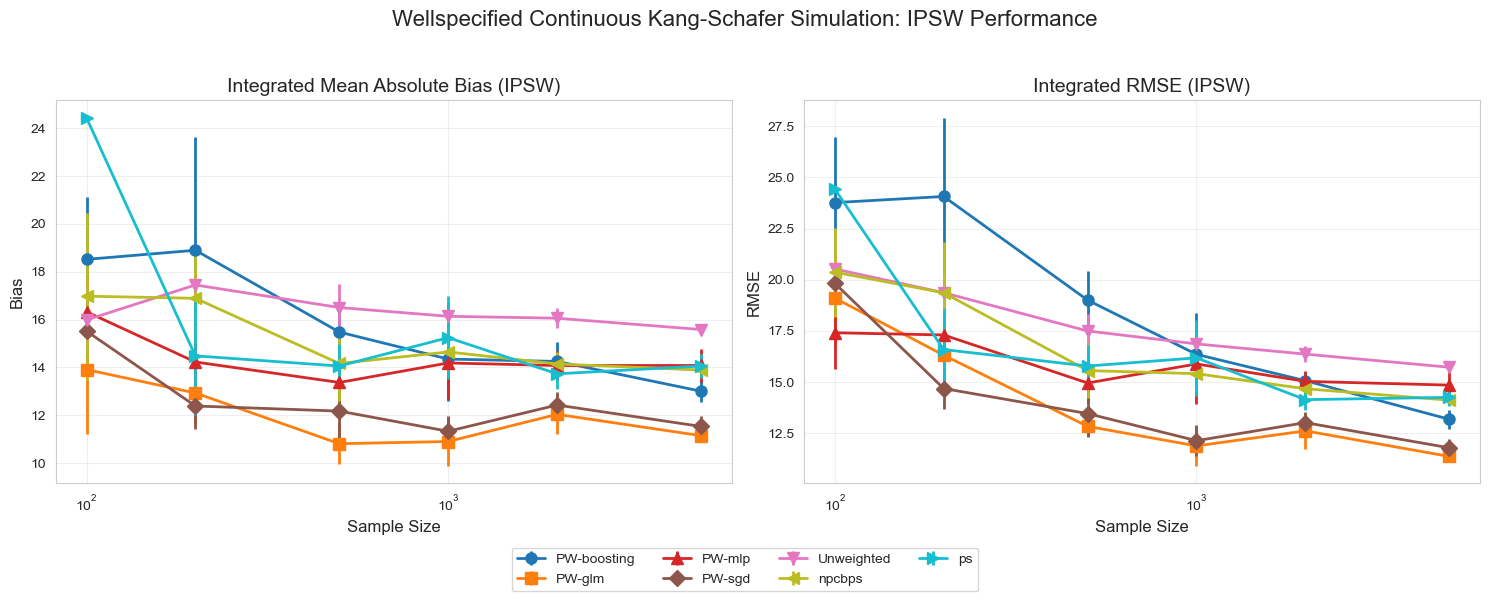

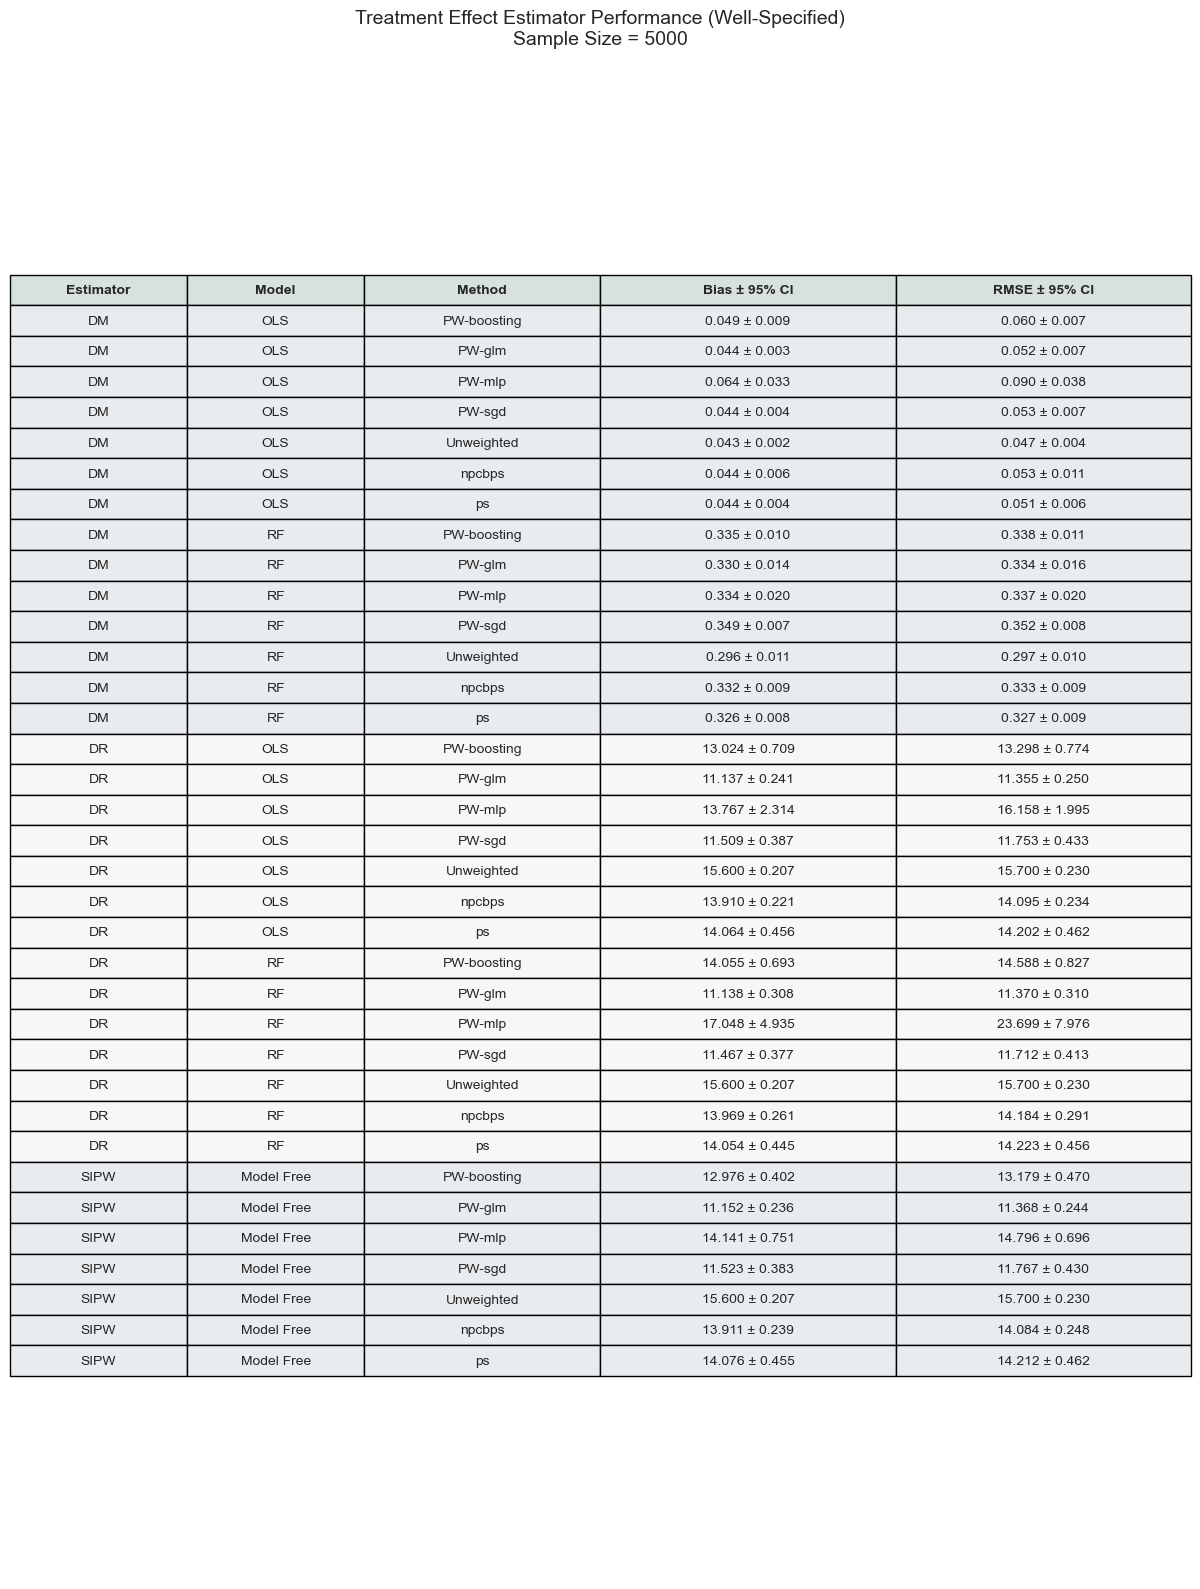

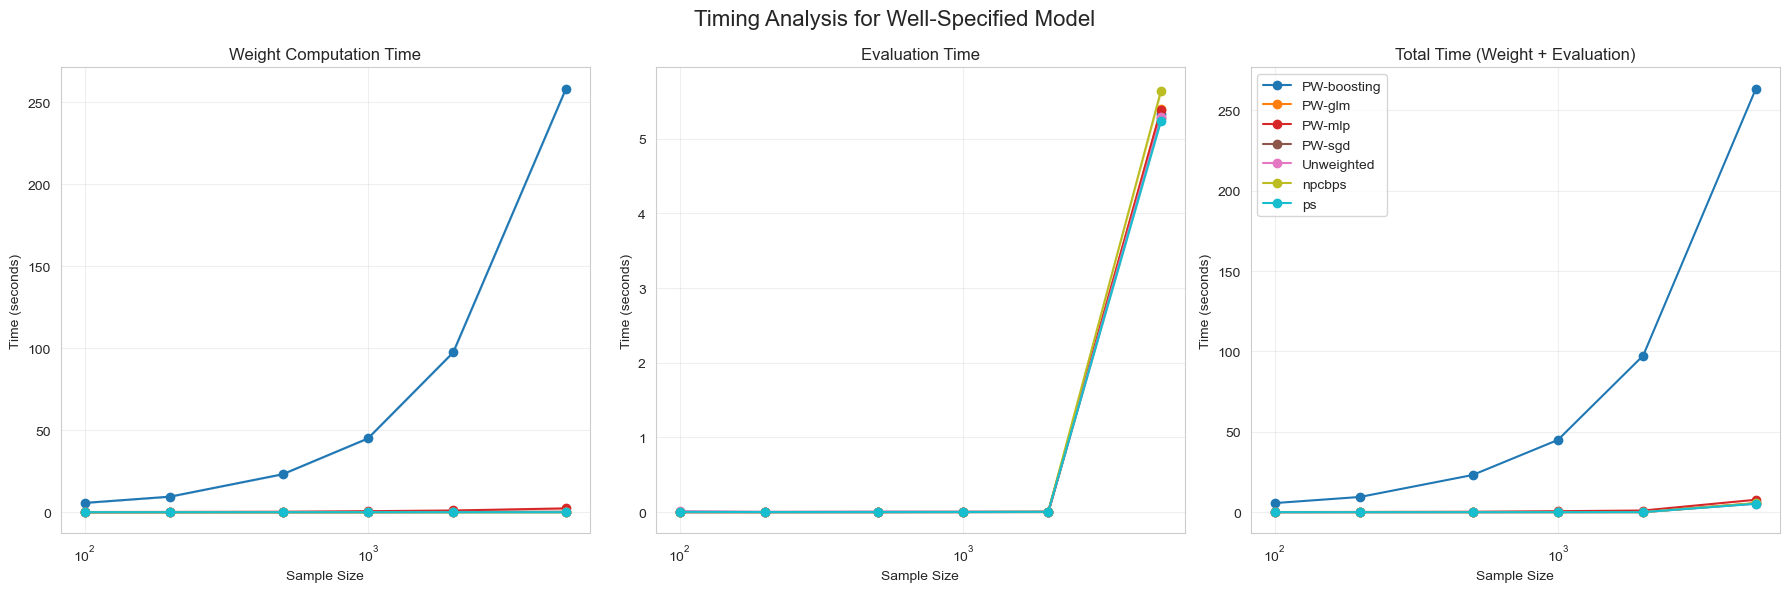

In [9]:
sample_sizes = [100, 200, 500, 1000, 2000,5000]
n_sims = 5 # Even more reduced for testing
methods = ['Unweighted', 'ps', 'npcbps', 'PW-glm', 'PW-boosting','PW-sgd', 'PW-mlp']  # Reduced set of methods

# Run well-specified simulation
start_time = time.time()
well_specified_results = run_simulation_parallel(
    sample_sizes=sample_sizes,
    n_sims=n_sims,
    methods=methods,
    misspecified=False
)
print(f"Well-specified simulation completed in {time.time() - start_time:.1f} seconds")

# # Run misspecified simulation
# start_time = time.time()
# misspecified_results = run_simulation_parallel(
#     sample_sizes=sample_sizes,
#     n_sims=n_sims,
#     methods=methods,
#     misspecified=True
# )
# print(f"Misspecified simulation completed in {time.time() - start_time:.1f} seconds")
# # 
# Plot IPSW results for both well-specified and misspecified
ipsw_fig_well = plot_ipsw_results(well_specified_results, misspecified=False )
#ipsw_fig_miss = plot_ipsw_results(misspecified_results, misspecified=True)


# Create tables for all estimators at highest sample size
max_sample_size = max(sample_sizes)
table_fig_well = create_estimator_table(well_specified_results, max_sample_size, "Well-Specified")
#table_fig_mis = create_estimator_table(misspecified_results, max_sample_size, "Misspecified")

runtime_fig_well=analyze_timing(well_specified_results, misspecified=False)
#runtime_fig_miss=analyze_timing(misspecified_results, misspecified=True)

Running well-specified continuous Kang-Schafer simulation...
  Sample size: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   25.7s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   26.2s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   29.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   30.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.


  Sample size: 200


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   35.0s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   37.6s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   49.3s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   49.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.


  Sample size: 500


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:  1.8min remaining:   47.5s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  1.9min remaining:   24.5s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  2.2min remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.


  Sample size: 1000


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:  3.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  3.4min remaining:   44.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  4.0min remaining:   15.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.


  Sample size: 2000


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:  6.5min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  6.6min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  7.9min remaining:   30.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.


  Sample size: 5000


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed: 23.6min remaining: 10.1min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 23.6min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 28.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 28.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.


Well-specified simulation completed in 2619.7 seconds
Running misspecified continuous Kang-Schafer simulation...
  Sample size: 100


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   30.4s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   30.7s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   36.0s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.


  Sample size: 200


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   43.5s remaining:   18.7s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   43.7s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   51.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   51.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.


  Sample size: 500


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:  1.4min remaining:   36.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  1.4min remaining:   18.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  1.7min remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.


  Sample size: 1000


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:  3.0min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  3.0min remaining:   39.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  3.7min remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.


  Sample size: 2000


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:  6.4min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  6.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  7.6min remaining:   29.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.


  Sample size: 5000


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed: 23.2min remaining:  9.9min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 23.3min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 27.8min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 27.8min finished


Misspecified simulation completed in 2535.6 seconds
Error in evaluate_treatment_effect for npcbps, sim 5, n=100: b'Extrapolation not allowed with blending'
Error in evaluate_treatment_effect for PW-glm, sim 5, n=100: b'Extrapolation not allowed with blending'
Error in evaluate_treatment_effect for PW-boosting, sim 5, n=100: b'Extrapolation not allowed with blending'
Error in evaluate_treatment_effect for PW-sgd, sim 5, n=100: b'Extrapolation not allowed with blending'
  Note: 8 test points trimmed for sim 11.
Error in evaluate_treatment_effect for PW-mlp, sim 11, n=100: b'Extrapolation not allowed with blending'
  Note: 4 test points trimmed for sim 23.
Error in evaluate_treatment_effect for Unweighted, sim 23, n=100: b'Extrapolation not allowed with blending'
Error in evaluate_treatment_effect for PW-glm, sim 23, n=100: b'Extrapolation not allowed with blending'
Error in evaluate_treatment_effect for PW-boosting, sim 23, n=100: b'Extrapolation not allowed with blending'
Error in evalu

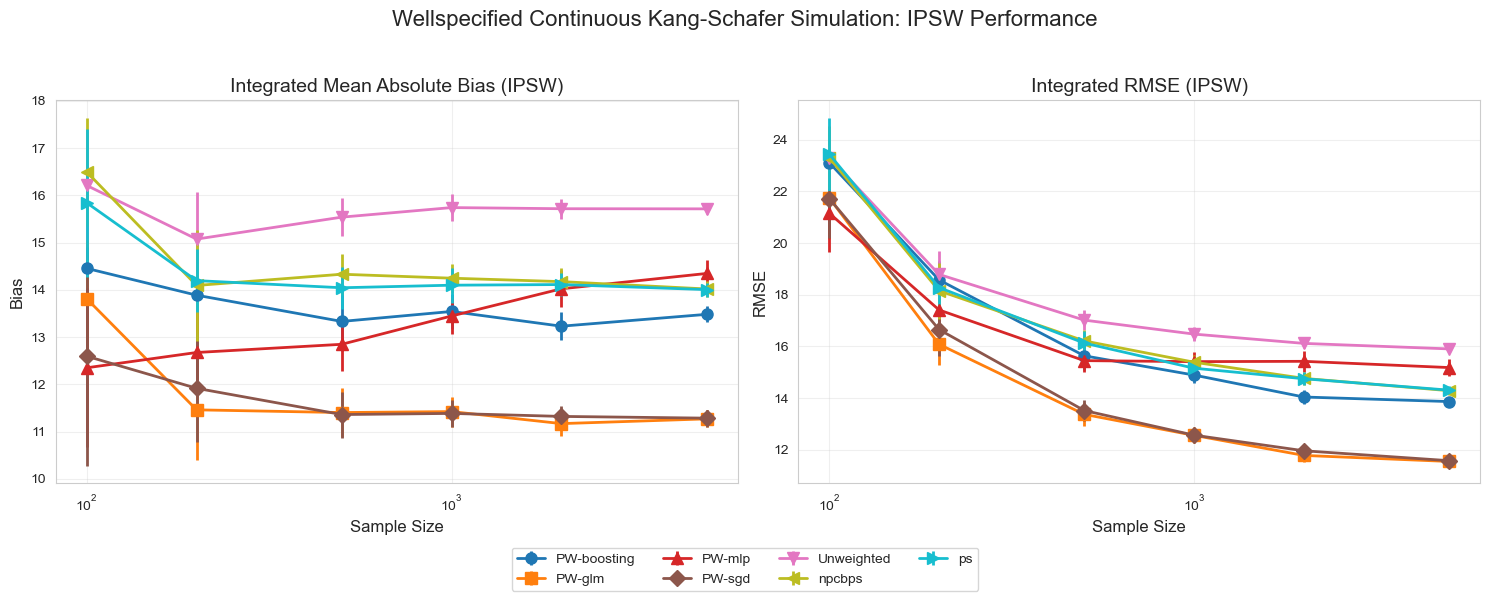

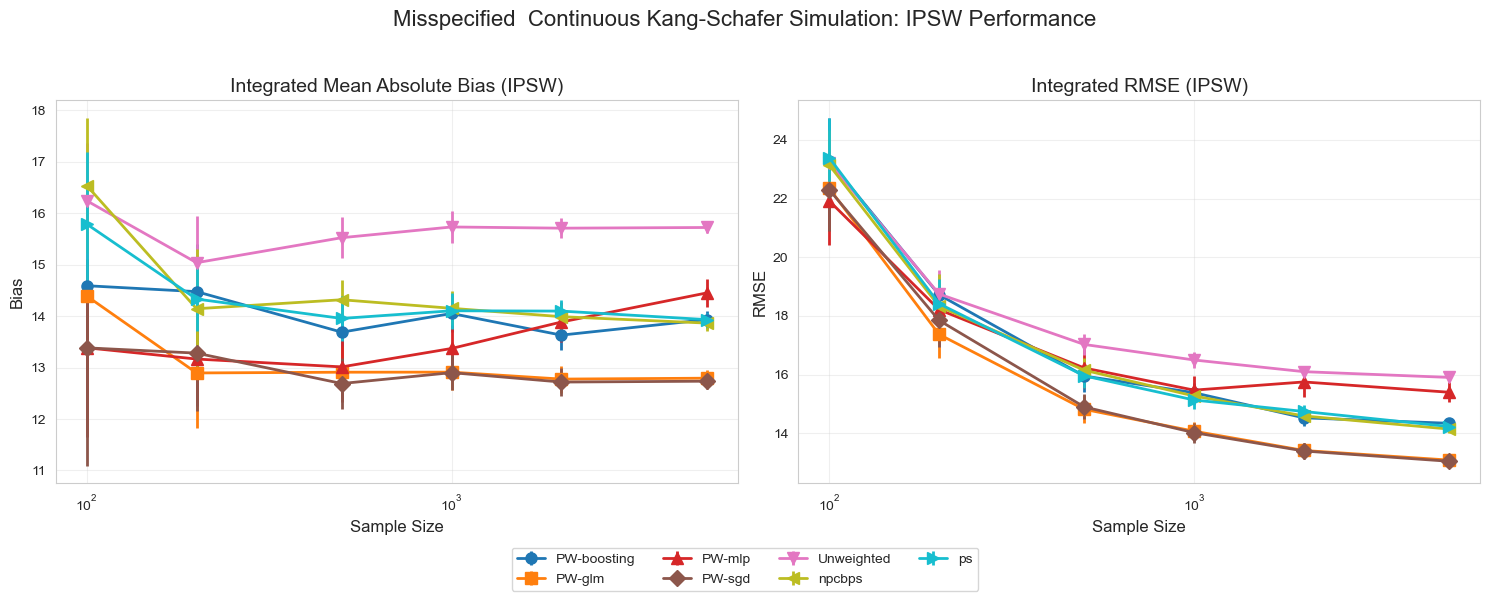

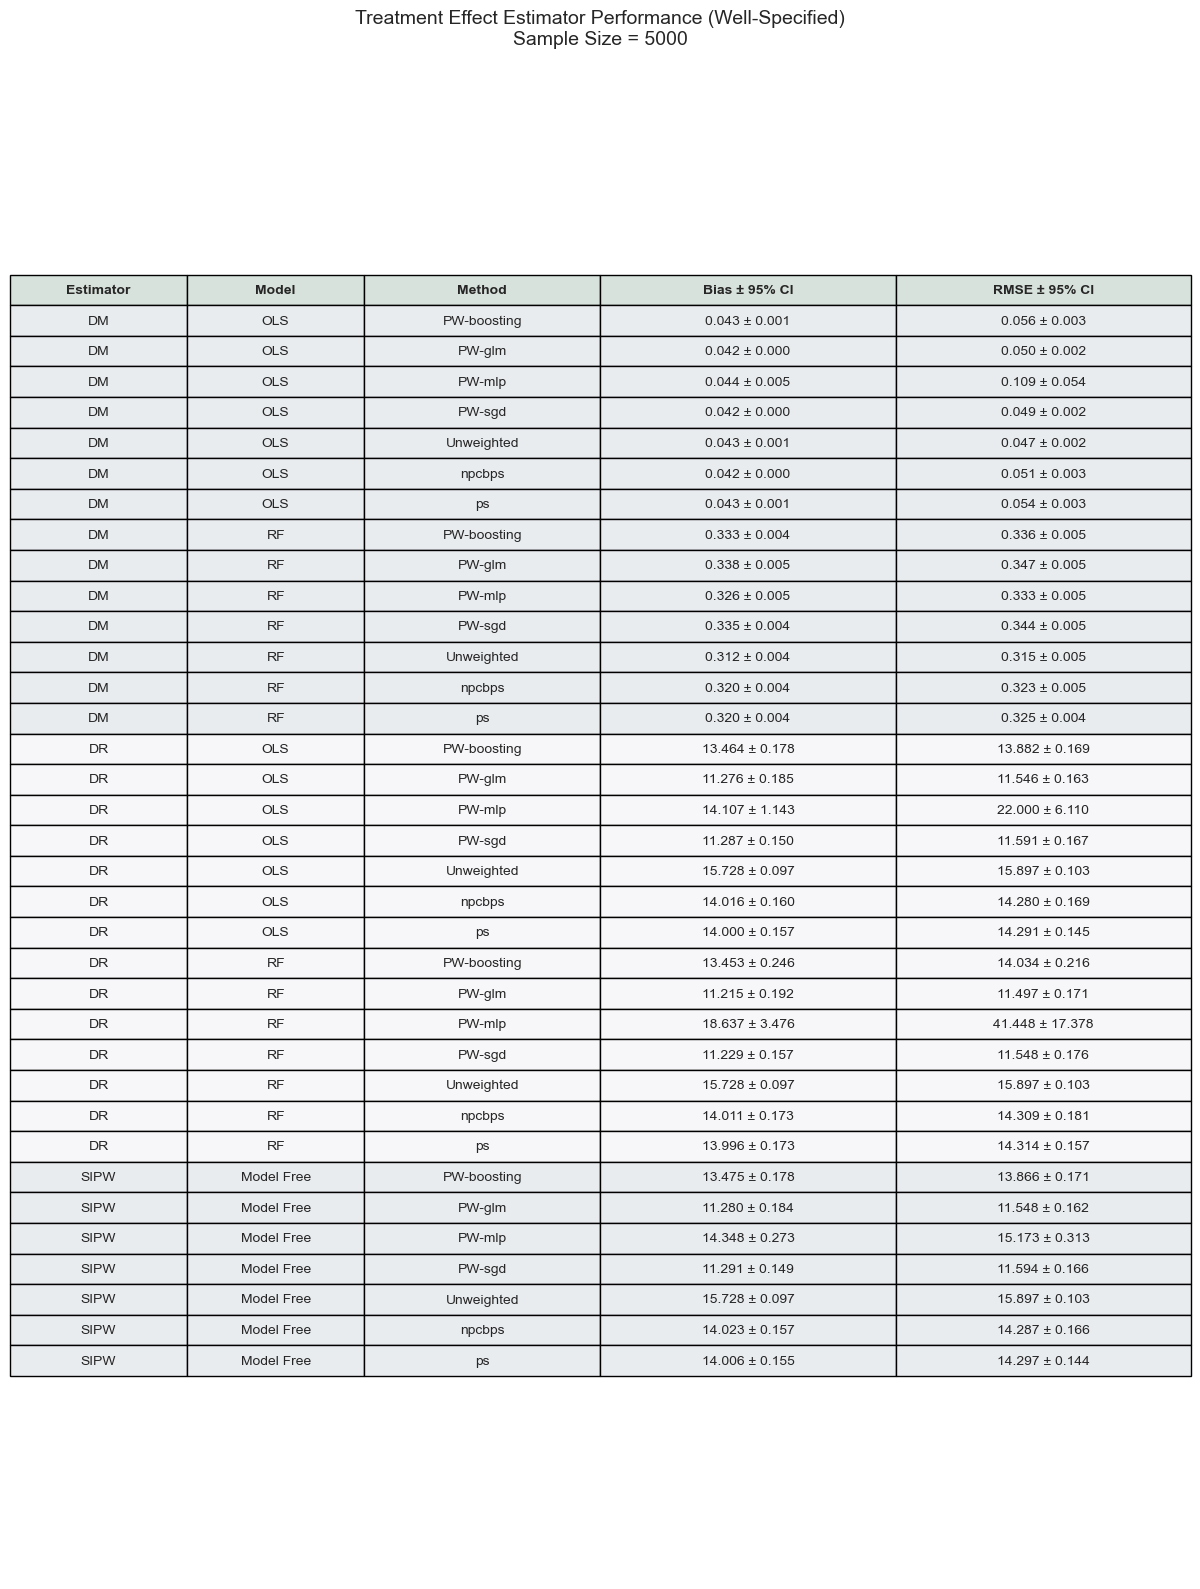

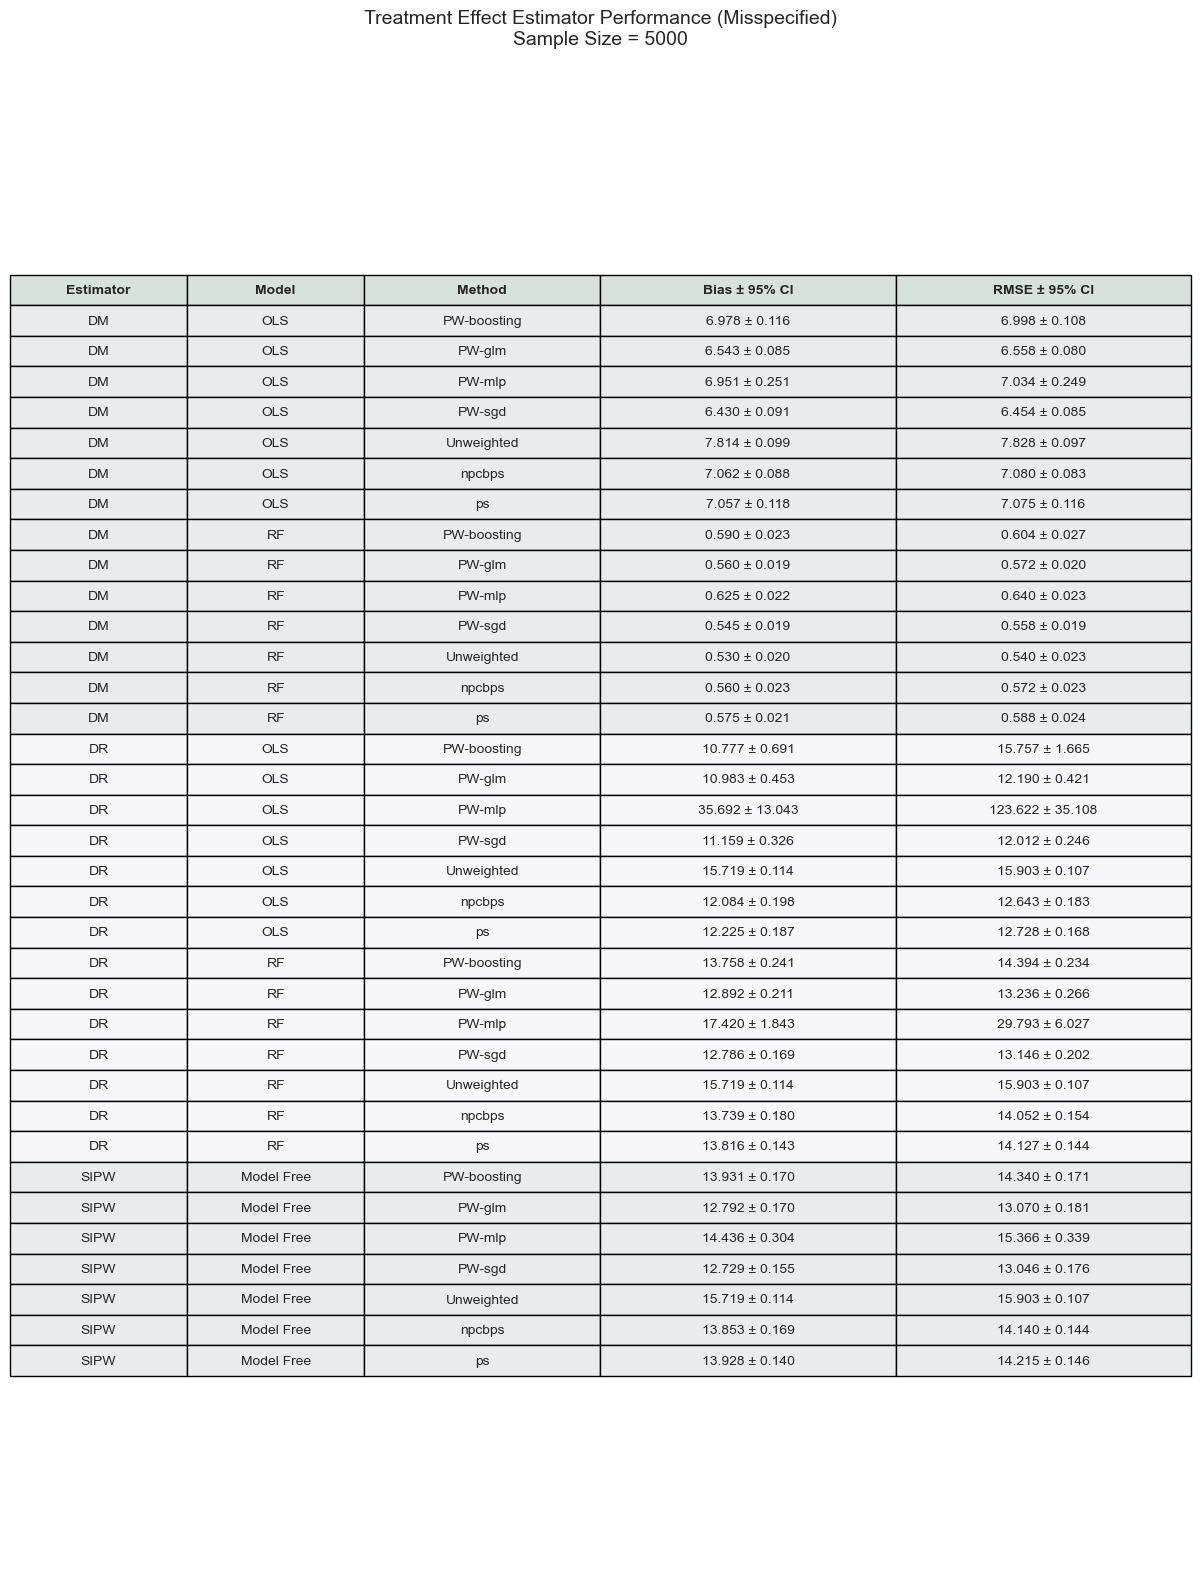

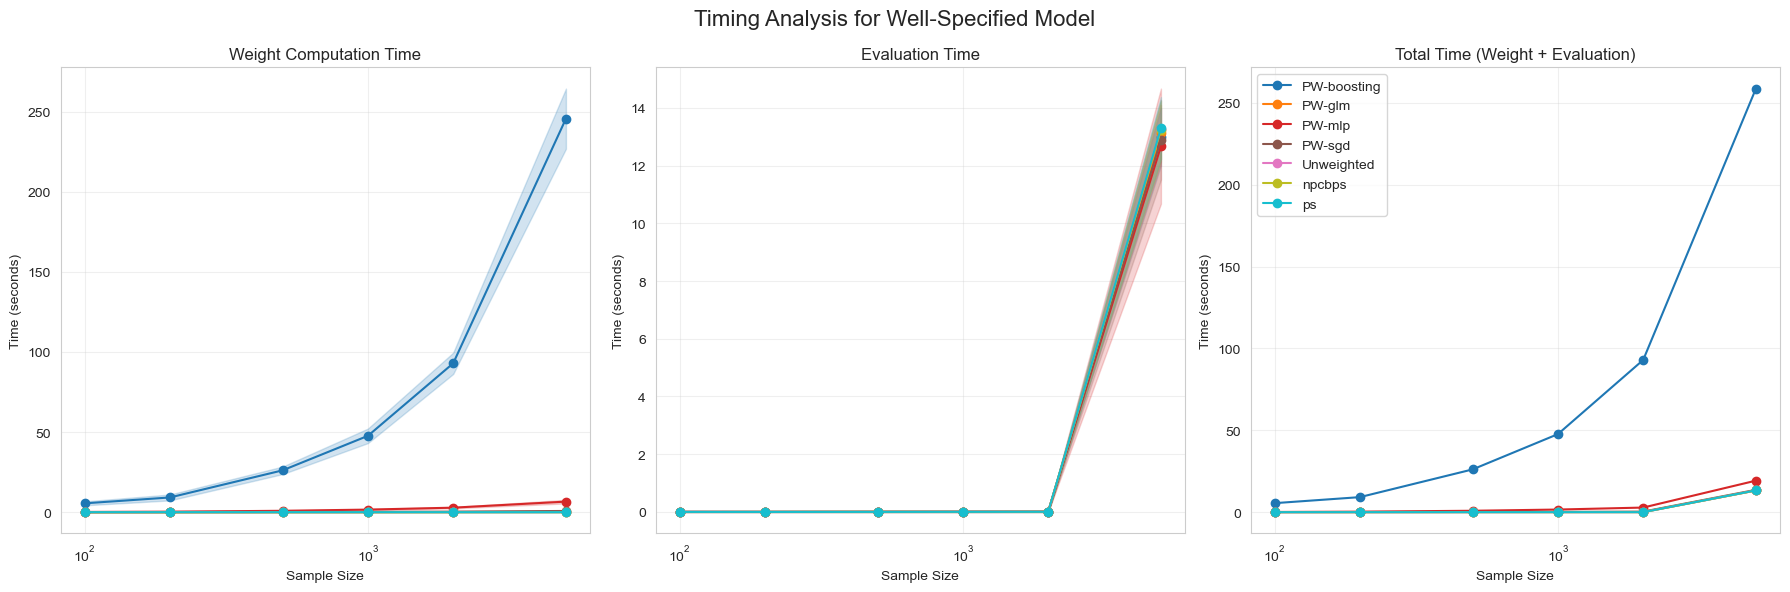

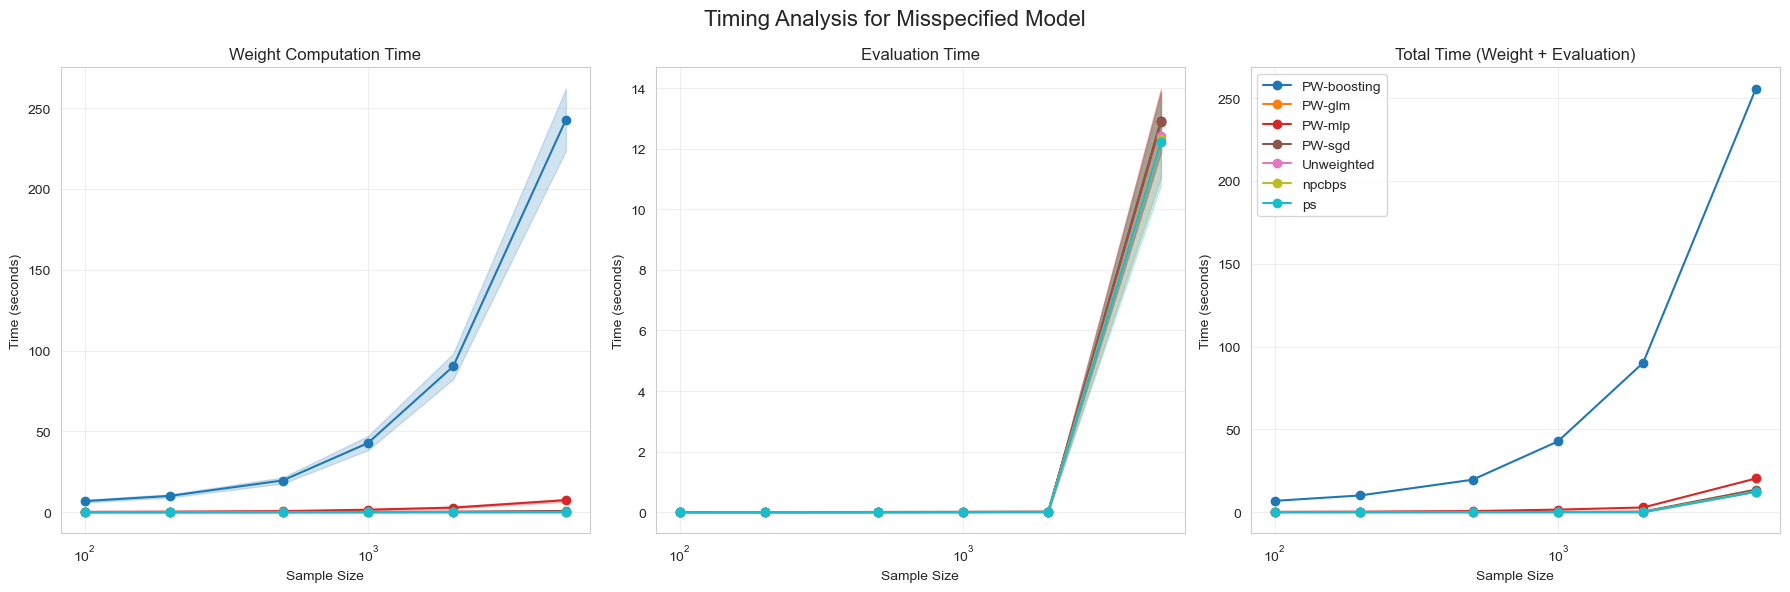